## Import Packages

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
%matplotlib inline

Reminder to self: when we use PNG together with `mpimg.imread`, the intensity of the pixels is between 0 and 1 (requiring a normalization) and the channels in the RGB order, if the image is JPEG and we use that same method, the intensity is between 0 and 255 ( in which case no normalization is required). For PNG images you can use `cv2.imread` which already leaves the intensity between 0 and 255 (however with the channels in the order BGR) or use `mpimg.imread` and do normalization.

## Define Detection Functions
These are largely derived from the "Object Detection" Lesson

In [2]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  block_norm= 'L2-Hys',
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to convert color spaces
def convert_color(img, color_space='RGB'):
    if color_space != 'RGB':
        if color_space == 'HSV':
            return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: return np.copy(img)      

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        feature_image = convert_color(image, color_space=color_space)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    feature_image = convert_color(image, color_space=color_space) 
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

## Data Exploration

In [3]:
# Read in training data sets
car_files = glob.glob('./vehicles/*/*.png')
noncar_files = glob.glob('./non-vehicles/*/*.png')
num_car_files = len(car_files)
num_noncar_files = len(noncar_files)
print('{} Car images in data set'.format(num_car_files))
print('{} Non-car images in data set'.format(num_noncar_files))

8792 Car images in data set
8968 Non-car images in data set


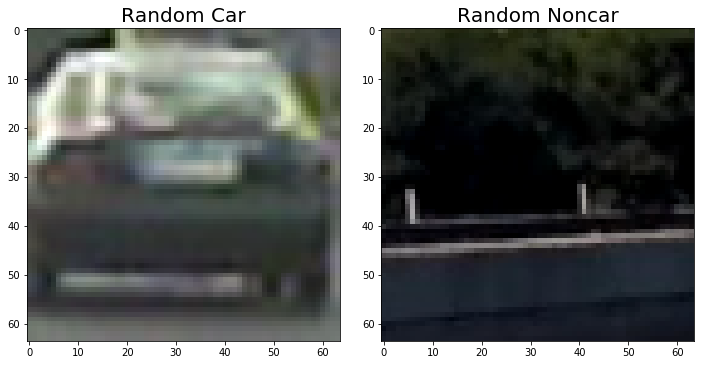

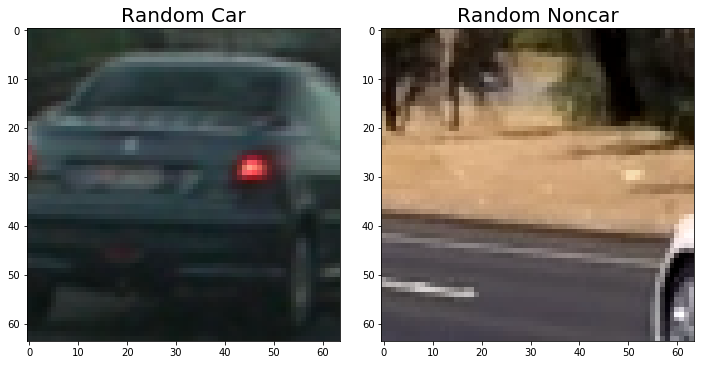

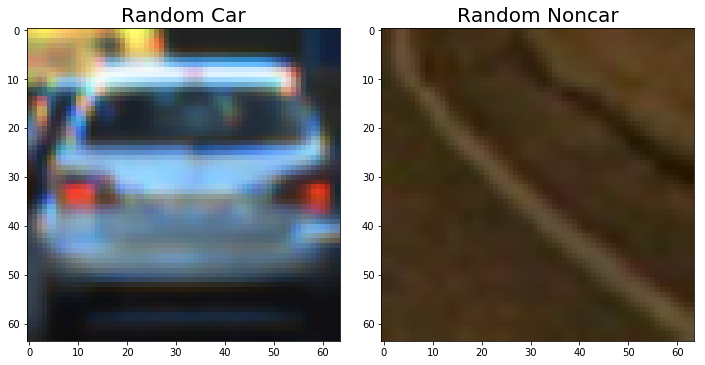

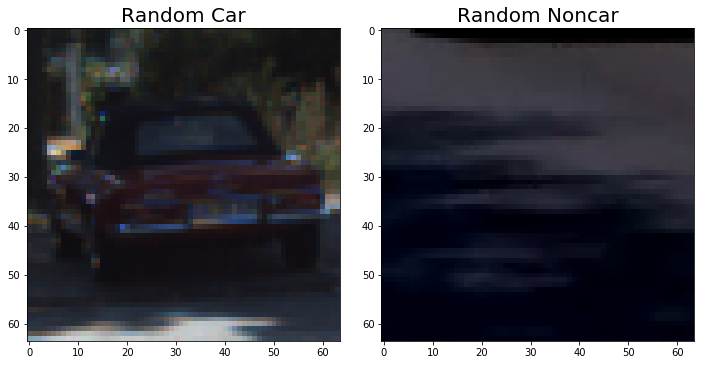

In [4]:
car_subsample = []
noncar_subsample = []
# for ind in range(3):
#     rand_ind_c = np.random.randint(0, num_car_files)
#     rand_ind_n = np.random.randint(0, num_noncar_files)
# The above lines were originally used, but to preserve predictability I froze the random indices
for rand_ind_c, rand_ind_n in ((1208,5594),(2641,8582),(4217,2820),(5757,4035)):
    car_subsample.append(car_files[rand_ind_c])
    noncar_subsample.append(noncar_files[rand_ind_n])
    
    random_car_img = mpimg.imread(car_files[rand_ind_c])
    random_noncar_img = mpimg.imread(noncar_files[rand_ind_n])

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    f.tight_layout()

    ax1.imshow(random_car_img)
    ax1.set_title('Random Car', fontsize=20)

    ax2.imshow(random_noncar_img)
    ax2.set_title('Random Noncar', fontsize=20)

    plt.savefig('./output_images/random_images_{}_{}'.format(rand_ind_c, rand_ind_n))

## Feature Extraction
### Color Exploration

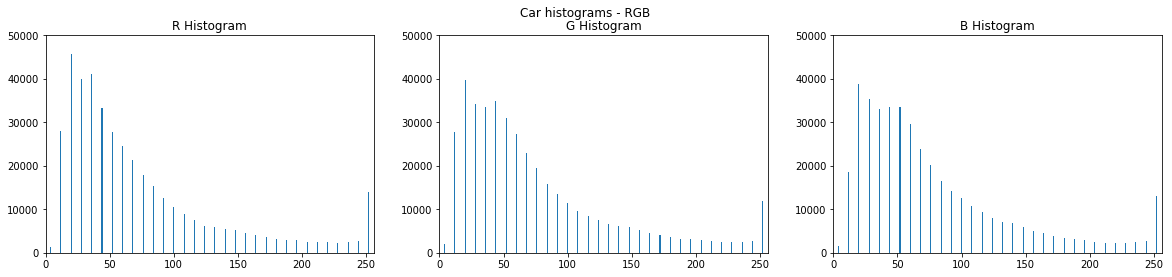

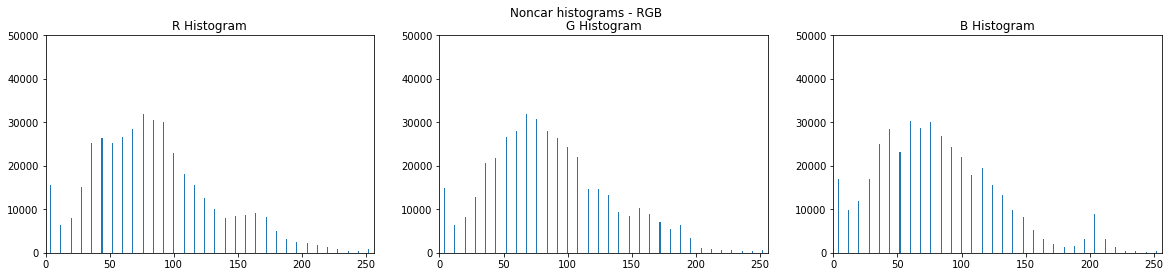

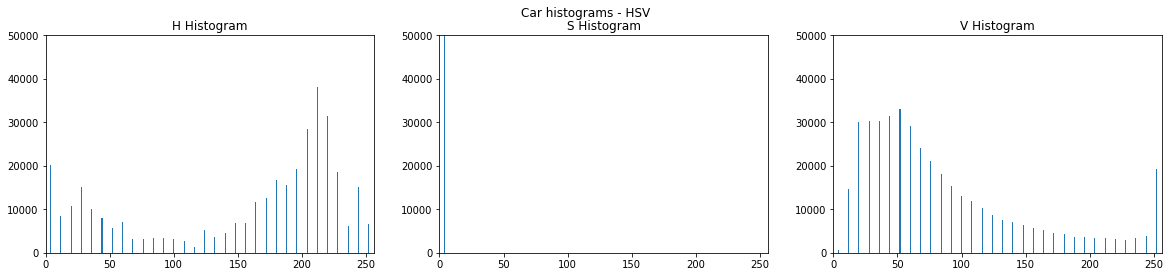

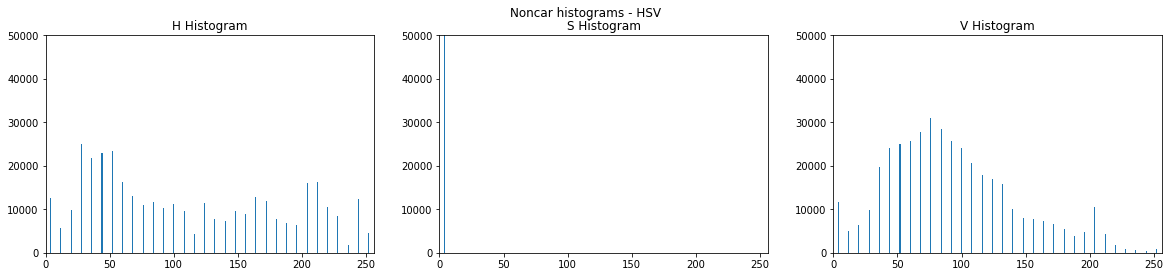

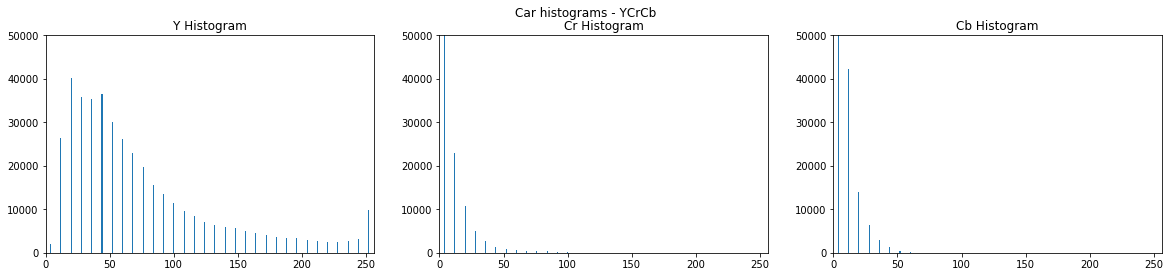

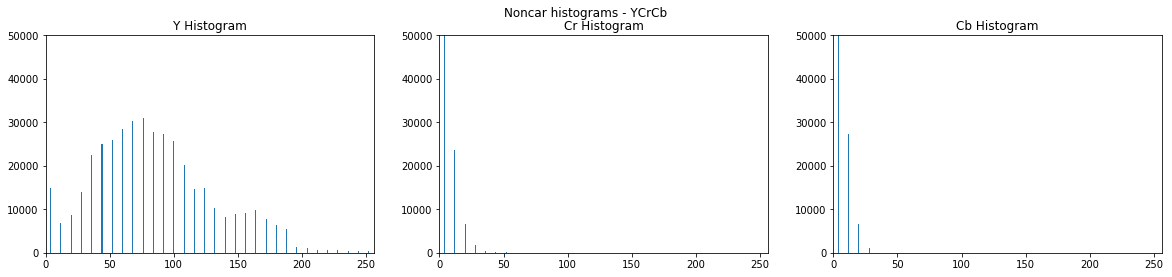

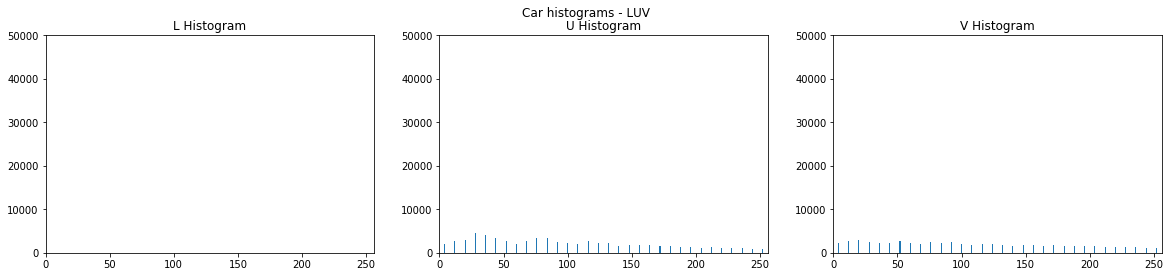

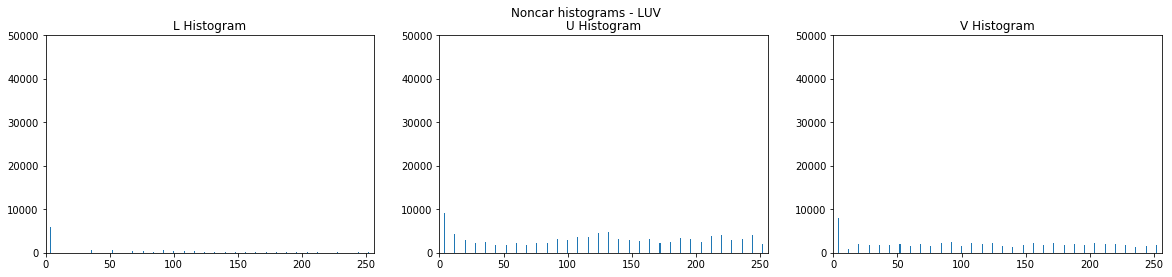

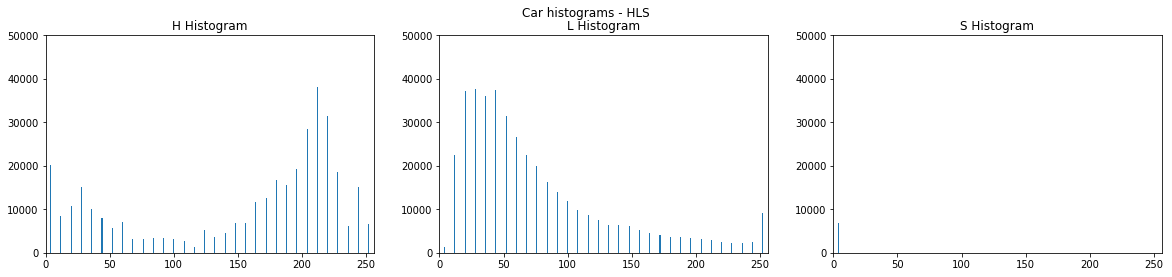

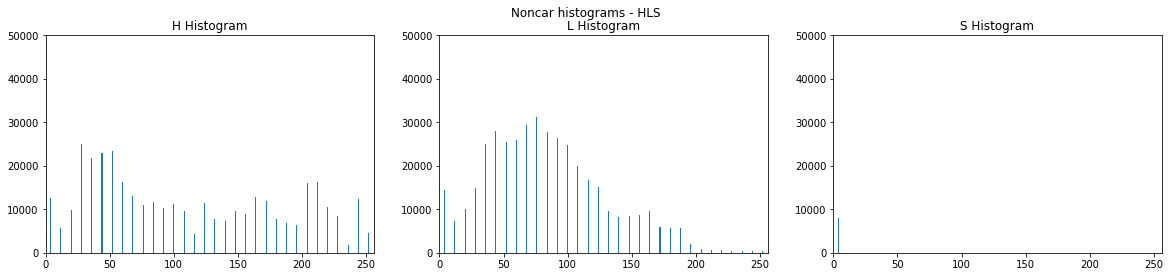

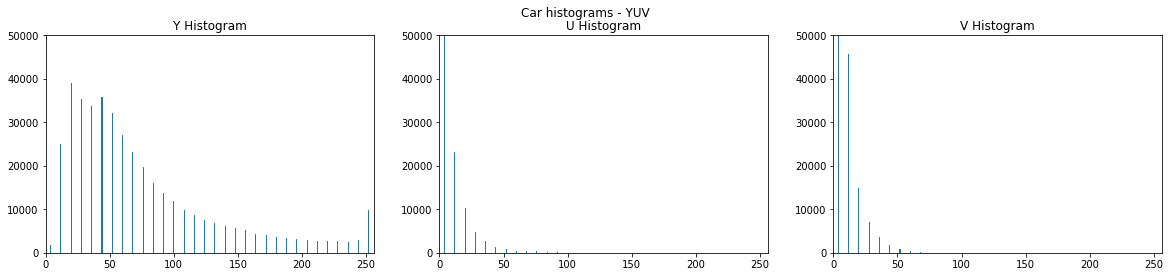

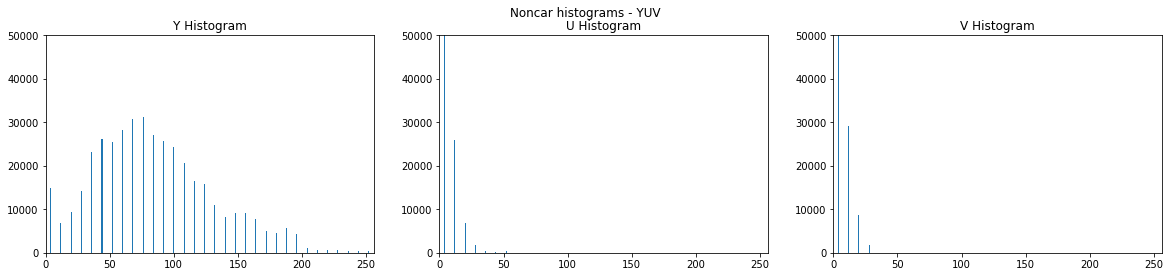

In [5]:
# Define a function that takes a list of images (same type), adds up their histograms for each color channel
# and prints out the images as well as the histograms

def aggregate_histogram(image_list, color_space, nbins=32, bins_range=(0, 256)):
    hist_vals = np.zeros((3,nbins))
    for image in image_list:
        orig_img = mpimg.imread(image)*255 # convert from 0-1 scaled
        img = convert_color(orig_img, color_space=color_space)
        hist_vals[0] = hist_vals[0] + np.histogram(img[:,:,0], bins=nbins, range=bins_range)[0]
        hist_vals[1] = hist_vals[1] + np.histogram(img[:,:,1], bins=nbins, range=bins_range)[0]
        hist_vals[2] = hist_vals[2] + np.histogram(img[:,:,2], bins=nbins, range=bins_range)[0]

    c_up = [i for i, c in enumerate(color_space) if c.isupper()]
    bin_edges = np.histogram(img[:,:,0], bins=nbins, range=bins_range)[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    fig = plt.figure(figsize=(20,4))
    plt.subplot(131)
    plt.bar(bin_centers, hist_vals[0])
    plt.xlim(0, 256)
    plt.ylim(0, 500*len(image_list))
    plt.title('{} Histogram'.format(color_space[:c_up[1]]))
    plt.subplot(132)
    plt.bar(bin_centers, hist_vals[1])
    plt.xlim(0, 256)
    plt.ylim(0, 500*len(image_list))
    plt.title('{} Histogram'.format(color_space[c_up[1]:c_up[2]]))
    plt.subplot(133)
    plt.bar(bin_centers, hist_vals[2])
    plt.xlim(0, 256)
    plt.ylim(0, 500*len(image_list))
    plt.title('{} Histogram'.format(color_space[c_up[2]:]))
    return bin_centers, hist_vals

color_spaces = ['RGB','HSV','YCrCb','LUV', 'HLS', 'YUV']

import random
car_samples = [random.choice(car_files) for i in range(100)]
noncar_samples = [random.choice(noncar_files) for i in range(100)]

for color in color_spaces:
    car_centers, car_values = aggregate_histogram(car_samples, color)
    plt.suptitle('Car histograms - {}'.format(color))
#     plt.savefig('./output_images/car_histograms_{}'.format(color)) // freeze for output consistency
    noncar_centers, noncar_values = aggregate_histogram(noncar_samples, color)
    plt.suptitle('Noncar histograms - {}'.format(color))
#     plt.savefig('./output_images/noncar_histograms_{}'.format(color))



### HOG Parameters

In [6]:
# Function that accepts an image and a color space and HOG images of all channels

def hog_plotter(image_name, color_space, orient=8, pix_per_cell=8, cell_per_block=2):
    img = mpimg.imread(image_name)
    color_image = convert_color(img, color_space=color_space)
    _, hog_image1 = get_hog_features(color_image[:,:,0], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
    _, hog_image2 = get_hog_features(color_image[:,:,1], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
    _, hog_image3 = get_hog_features(color_image[:,:,2], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
    fig = plt.figure(figsize=(20,3))
    plt.subplot(141)
    plt.imshow(color_image)
    plt.subplot(142)
    plt.imshow(hog_image1)
    plt.subplot(143)
    plt.imshow(hog_image2)
    plt.subplot(144)
    plt.imshow(hog_image3)


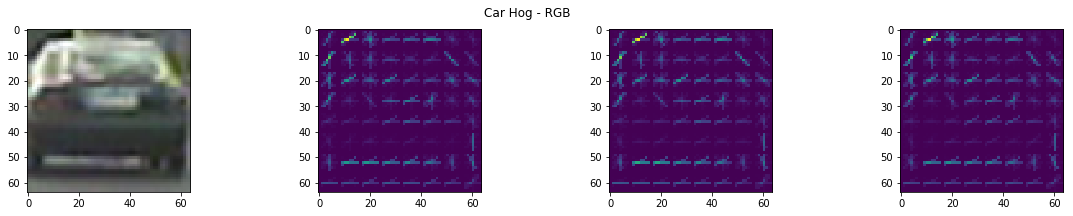

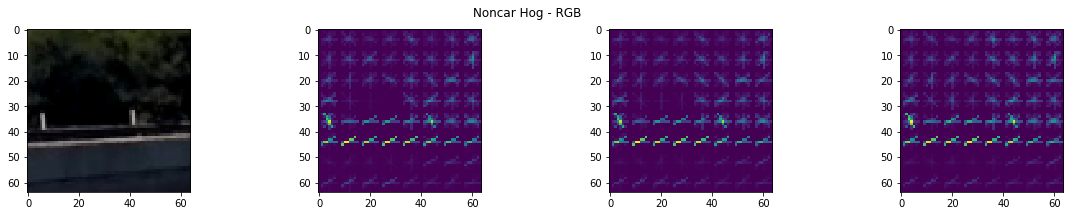

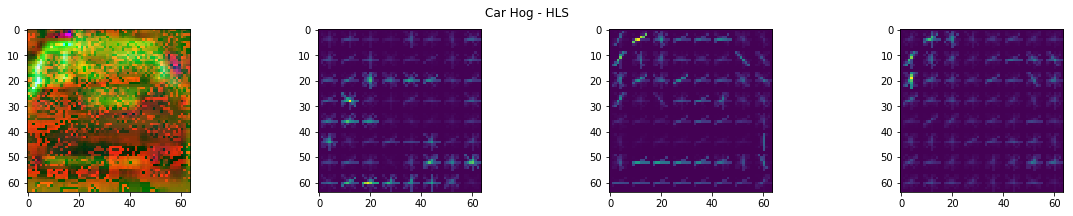

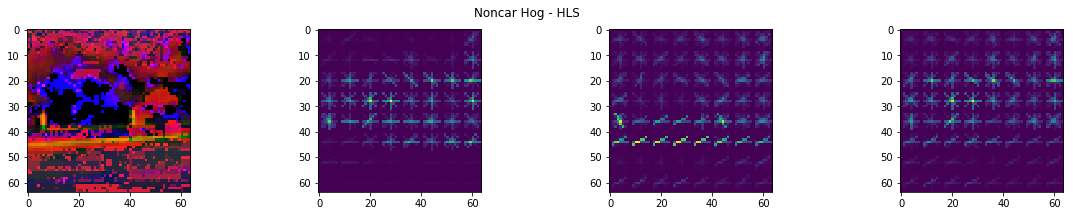

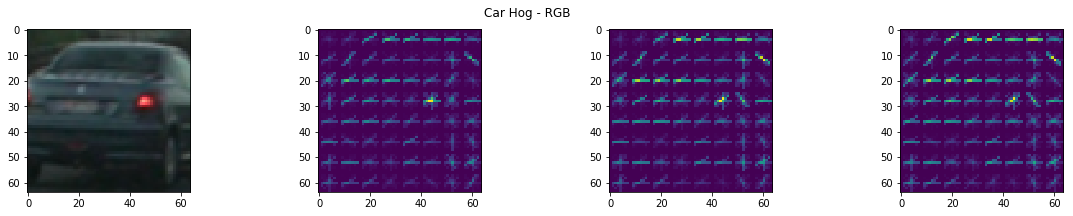

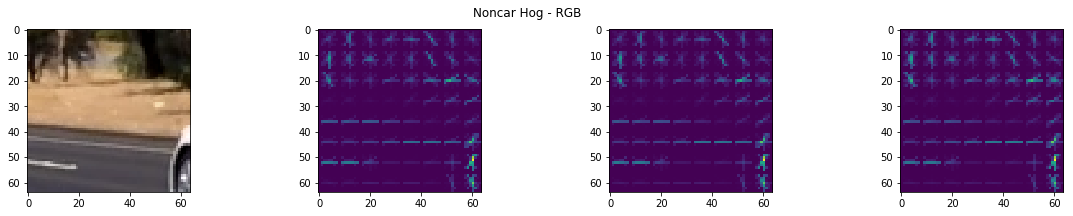

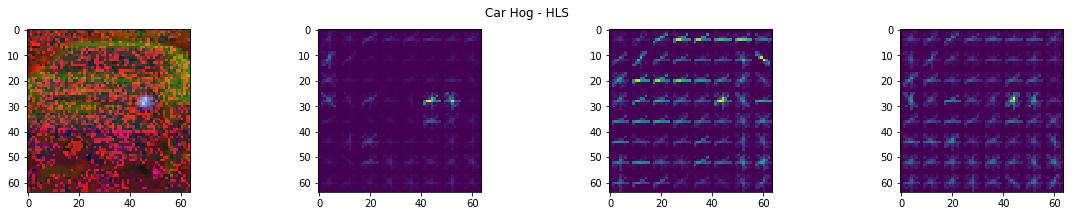

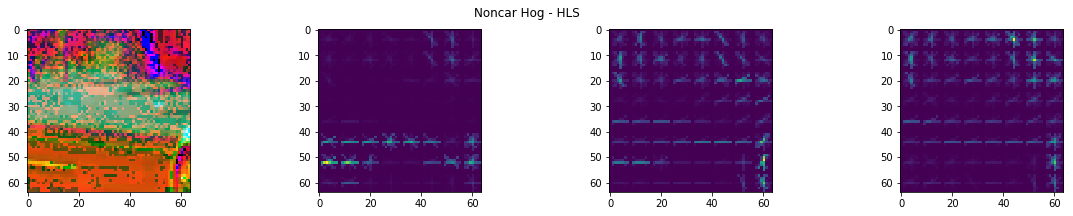

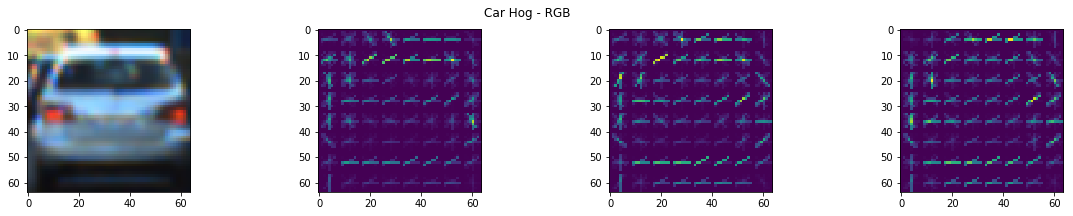

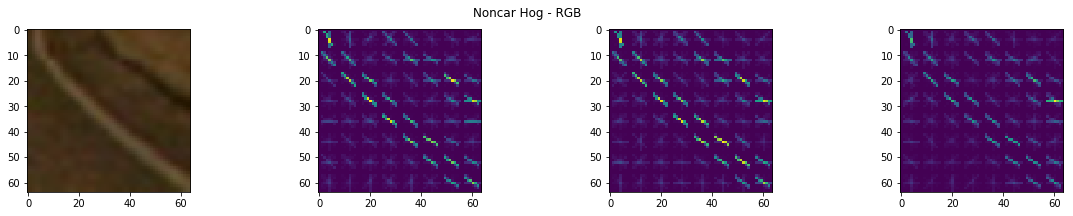

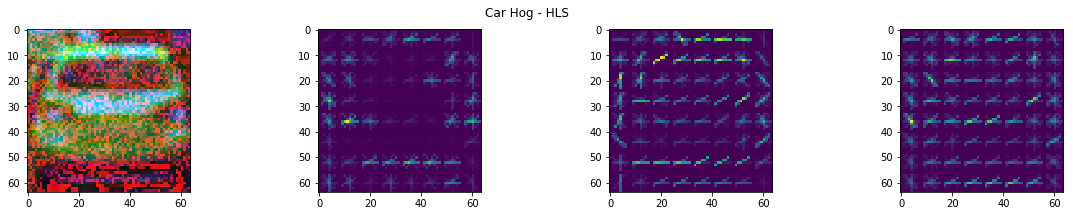

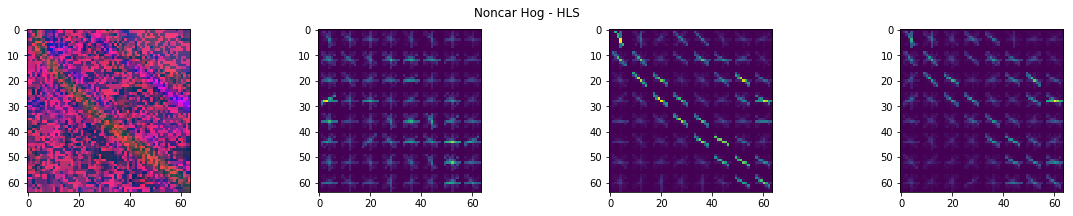

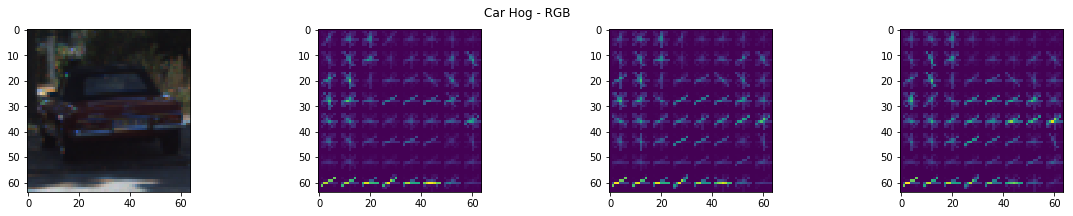

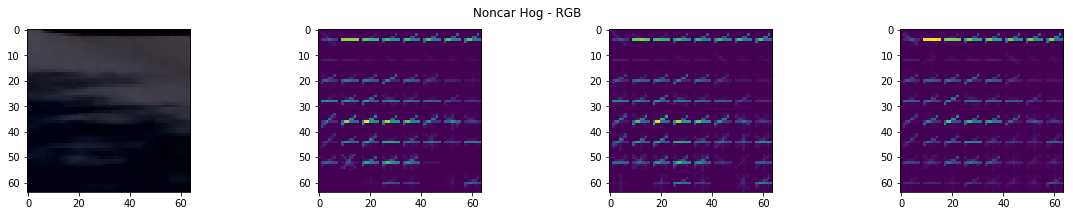

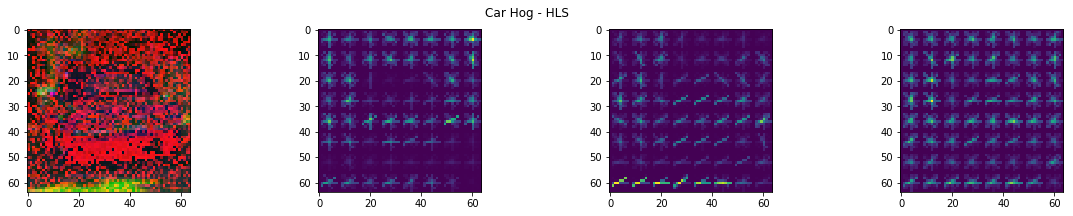

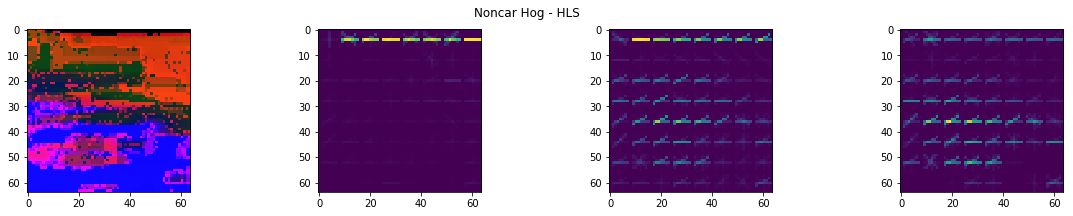

In [7]:
for ind in range(len(car_subsample)):
    car_image_name = car_subsample[ind]
    hog_plotter(car_image_name, 'RGB')
    plt.suptitle('Car Hog - RGB')
    plt.savefig('./output_images/car_{}_hog_RGB'.format(car_image_name.split('/')[-1][:-4]))
    noncar_image_name = noncar_subsample[ind]
    hog_plotter(noncar_image_name, 'RGB')
    plt.suptitle('Noncar Hog - RGB')
    plt.savefig('./output_images/noncar_{}_hog_RGB'.format(noncar_image_name.split('/')[-1][:-4]))
    hog_plotter(car_image_name, 'HLS')
    plt.suptitle('Car Hog - HLS')
    plt.savefig('./output_images/car_{}_hog_HLS'.format(car_image_name.split('/')[-1][:-4]))
    hog_plotter(noncar_image_name, 'HLS')
    plt.suptitle('Noncar Hog - HLS')
    plt.savefig('./output_images/noncar_{}_hog_HLS'.format(noncar_image_name.split('/')[-1][:-4]))


#### Trying fitting more pixels per cell

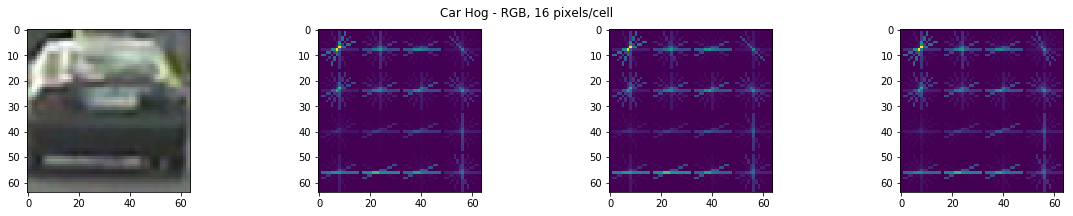

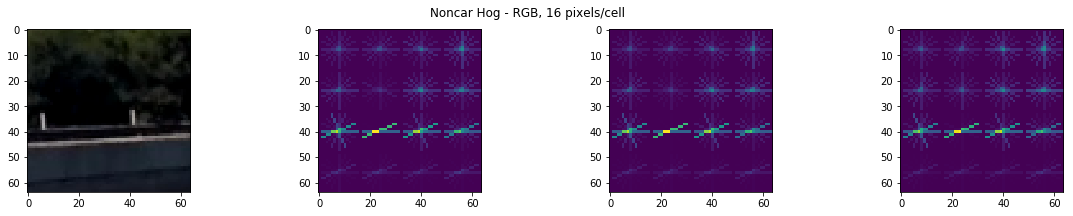

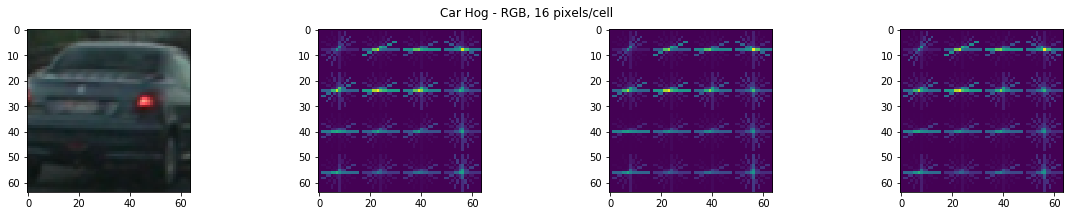

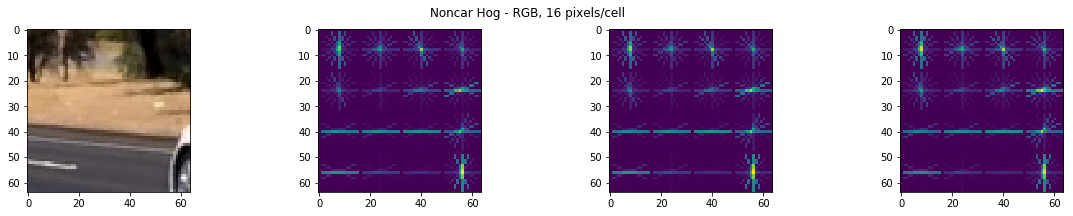

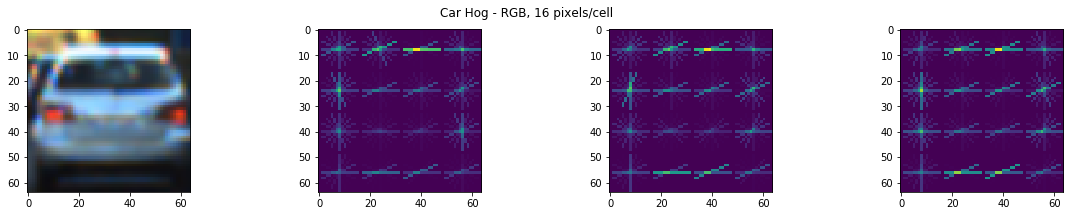

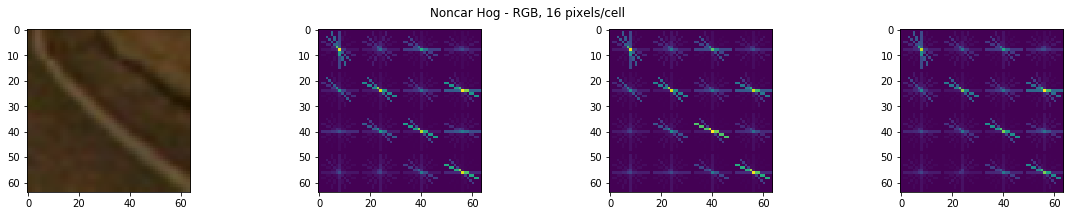

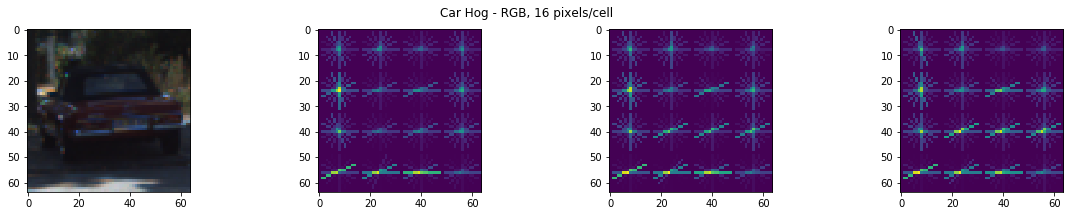

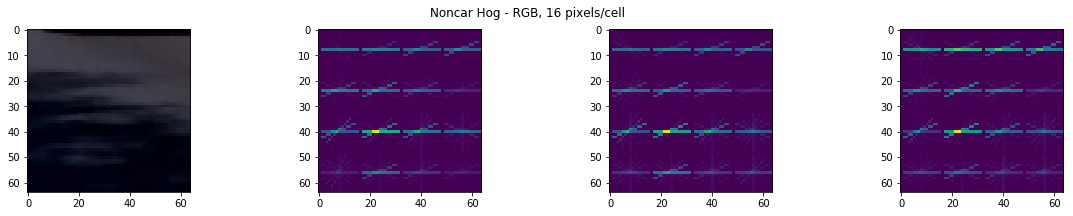

In [30]:
for ind in range(len(car_subsample)):
    car_image_name = car_subsample[ind]
    noncar_image_name = noncar_subsample[ind]
    hog_plotter(car_image_name, 'RGB', pix_per_cell=16)
    plt.suptitle('Car Hog - RGB, 16 pixels/cell')
    plt.savefig('./output_images/car_{}_hog_RGB_pix{}'.format(car_image_name.split('/')[-1][:-4], 16))
    hog_plotter(noncar_image_name, 'RGB', pix_per_cell=16)
    plt.suptitle('Noncar Hog - RGB, 16 pixels/cell')
    plt.savefig('./output_images/noncar_{}_hog_RGB_pix{}'.format(noncar_image_name.split('/')[-1][:-4], 16))

#### Less Cells per block

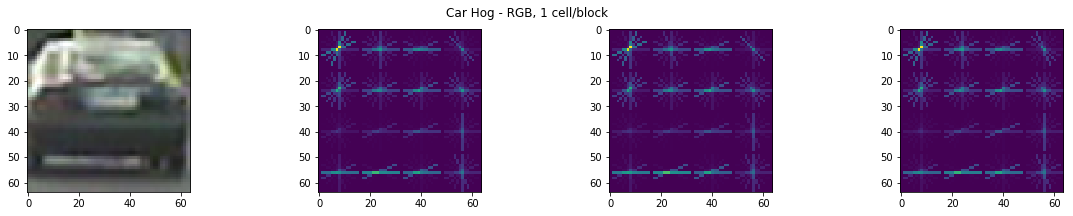

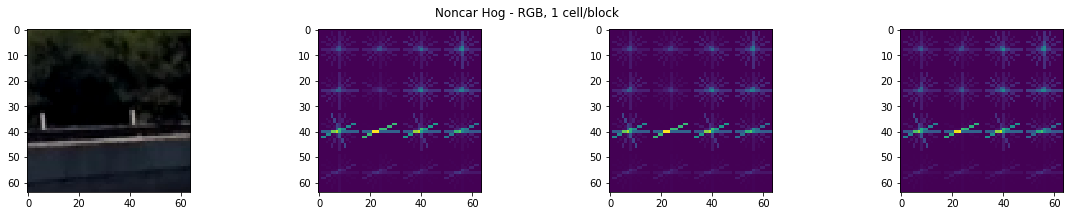

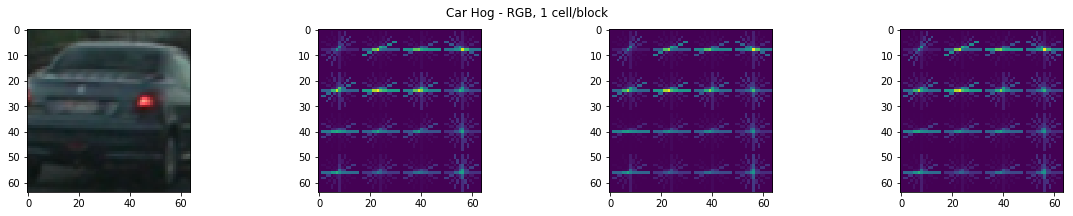

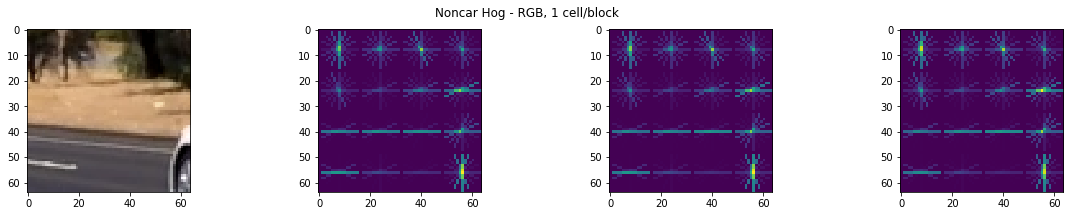

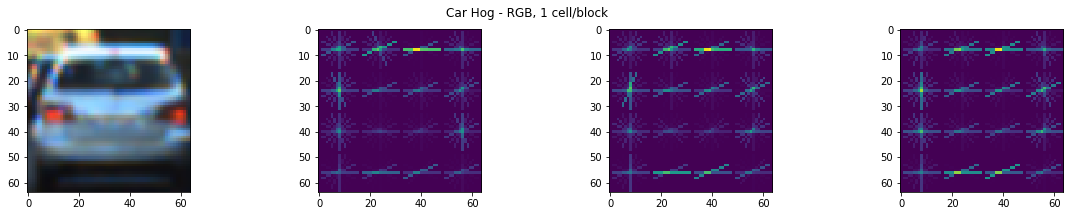

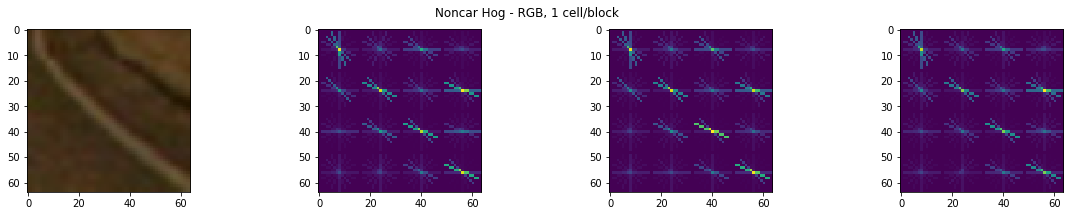

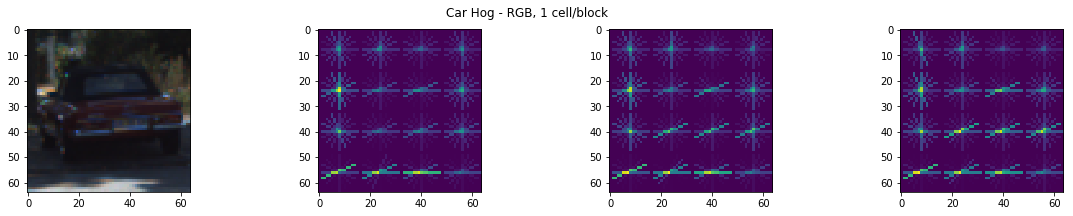

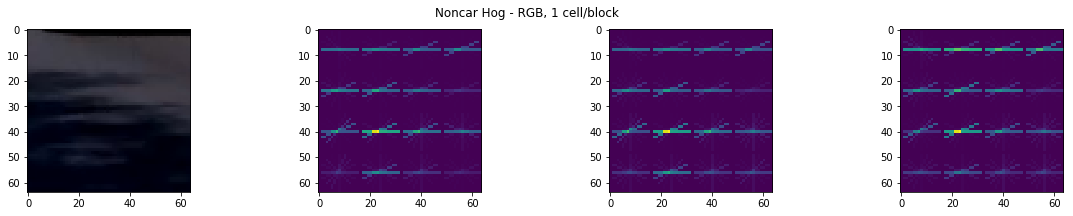

In [8]:
for ind in range(len(car_subsample)):
    car_image_name = car_subsample[ind]
    noncar_image_name = noncar_subsample[ind]
    hog_plotter(car_image_name, 'RGB', pix_per_cell=16, cell_per_block=1)
    plt.suptitle('Car Hog - RGB, 1 cell/block')
    plt.savefig('./output_images/car_{}_hog_RGB_pix16_blk1'.format(car_image_name.split('/')[-1][:-4], 16))
    hog_plotter(noncar_image_name, 'RGB', pix_per_cell=16, cell_per_block=1)
    plt.suptitle('Noncar Hog - RGB, 1 cell/block')
    plt.savefig('./output_images/noncar_{}_hog_RGB_pix16_blk1'.format(noncar_image_name.split('/')[-1][:-4], 16))

### Training the linear classifier

In [10]:
from sklearn.model_selection import train_test_split

hist_bins = 32
orient = 9
pix_per_cell = 16
cell_per_block = 4
color_space = 'YCrCb'
spatial_size = (32,32)
spatial_feat = False


car_features = extract_features(car_files, color_space=color_space, hist_bins=hist_bins, spatial_size=spatial_size,
                                orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel='ALL',
                                spatial_feat=spatial_feat, hist_feat=True, hog_feat = True)

notcar_features = extract_features(noncar_files, color_space=color_space, hist_bins=hist_bins,
                                orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel='ALL',
                                spatial_feat=spatial_feat, hist_feat=True, hog_feat = True)

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)
    
# Fit a per-column scaler only on the training data
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X_train and X_test
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Feature vector length: 528
1.74 Seconds to train SVC...
Test Accuracy of SVC =  0.9749
My SVC predicts:  [ 1.  0.  1.  0.  0.  1.  0.  0.  1.  1.]
For these 10 labels:  [ 1.  0.  1.  0.  0.  1.  0.  0.  1.  1.]
0.00108 Seconds to predict 10 labels with SVC


## Sliding Window Search

<IPython.core.display.Javascript object>


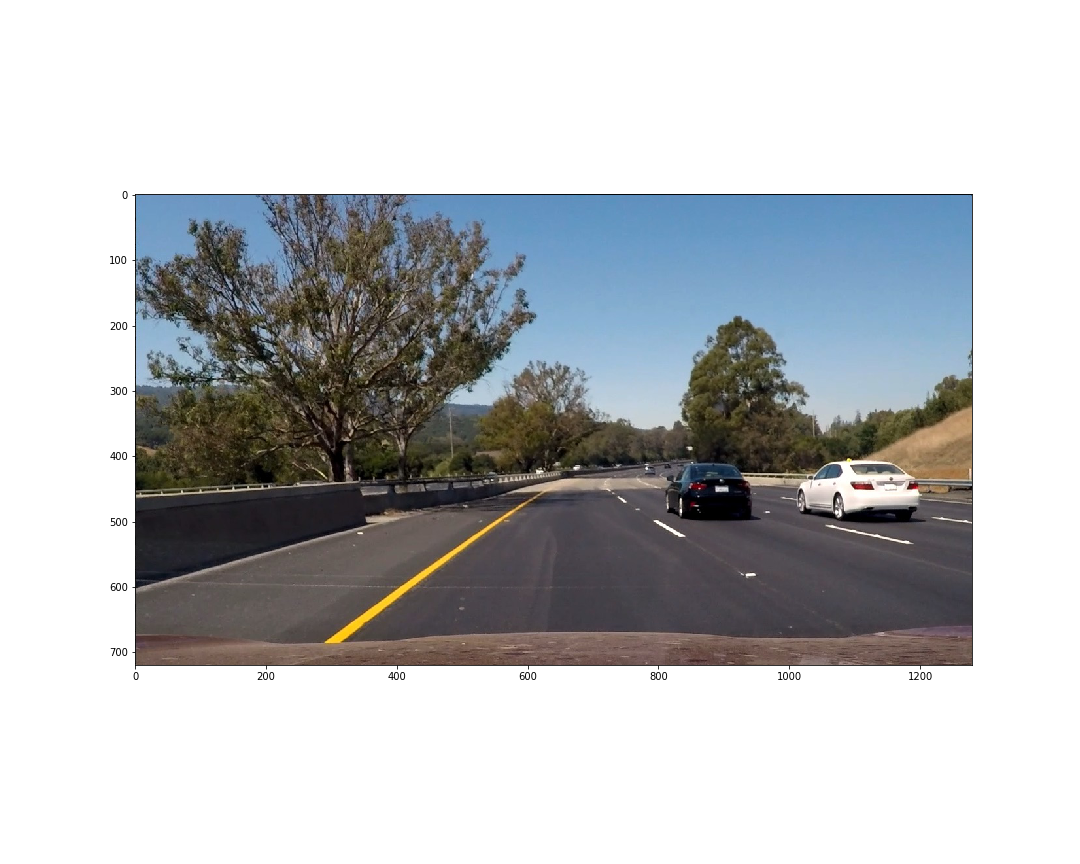

In [119]:
%matplotlib notebook
fig = plt.figure(figsize=(15,12))
plt.imshow(img)

In [11]:

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, color_space, xstart, xstop, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, spatial_feat):
#     draw_img = np.copy(img)
    img = img.astype(np.float32)/255

    img_tosearch = img[ystart:ystop,xstart:xstop,:]
    ctrans_tosearch = convert_color(img_tosearch, color_space=color_space)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = pix_per_cell*cell_per_block
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    bboxes = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            if spatial_feat:
                test_features = X_scaler.transform(np.hstack((hist_features, spatial_features, hog_features)).reshape(1, -1))
            else:
                test_features = X_scaler.transform(np.hstack((hist_features, hog_features)).reshape(1, -1))
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                bboxes.append(((xbox_left + xstart, ytop_draw+ystart),(xbox_left+win_draw+xstart,ytop_draw+win_draw+ystart)))
#                 cv2.rectangle(draw_img,(xbox_left + xstart, ytop_draw+ystart),(xbox_left+win_draw+xstart,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return bboxes

### Playing around with windows and scale

In [12]:
def tiered_window_search(image):
    bboxes = []
    
    xstart = 500
    xstop = 850
    ystart = 400
    ystop = 475
    scale = 0.5

    bboxes = bboxes + find_cars(image, color_space, xstart, xstop, ystart, ystop, scale, svc, X_scaler,
                        orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, spatial_feat)
    
    xstart = 0
    xstop = 1200
    ystart = 400
    ystop = 550
    scale = 1
    
    bboxes = bboxes + find_cars(image, color_space, xstart, xstop, ystart, ystop, scale, svc, X_scaler,
                        orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, spatial_feat)
    
    ystart = 400
    ystop = 650
    scale = 1.5
    
    bboxes = bboxes + find_cars(image, color_space, xstart, xstop, ystart, ystop, scale, svc, X_scaler,
                        orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, spatial_feat)
    
    ystart = 450
    ystop = 700
    scale = 2
    
    bboxes = bboxes + find_cars(image, color_space, xstart, xstop, ystart, ystop, scale, svc, X_scaler,
                        orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, spatial_feat)
    
    return bboxes

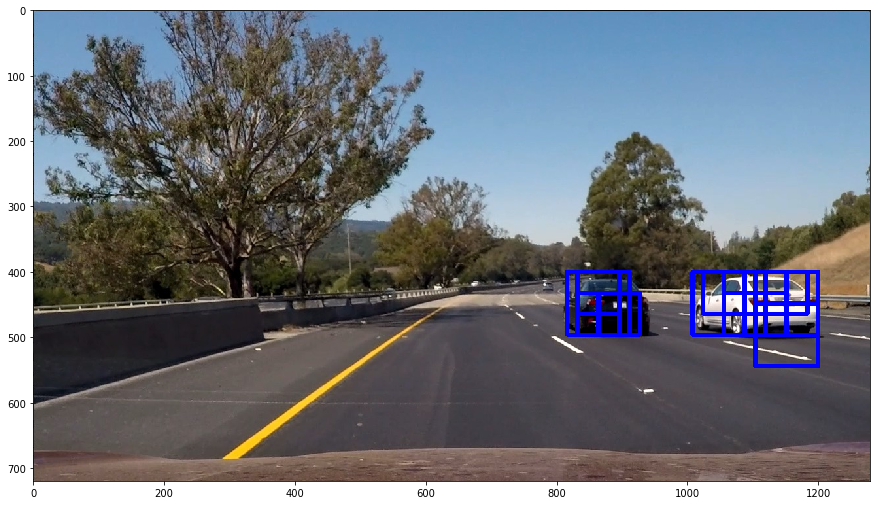

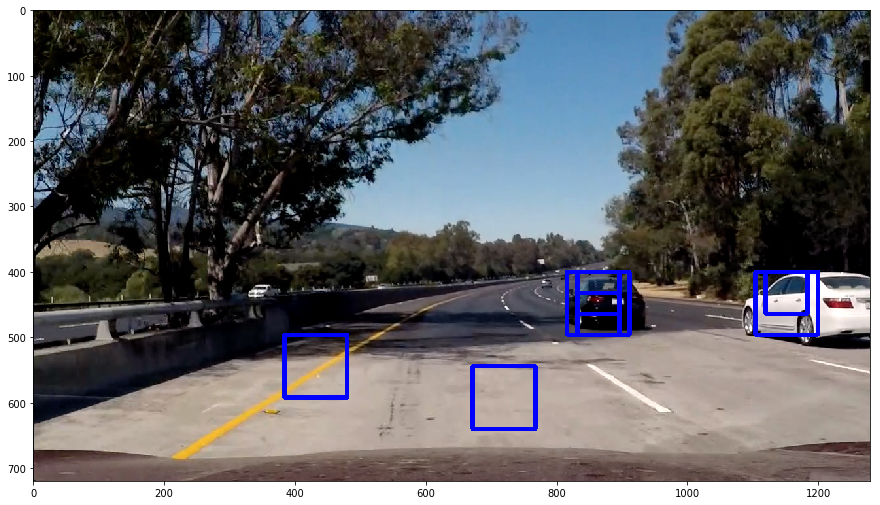

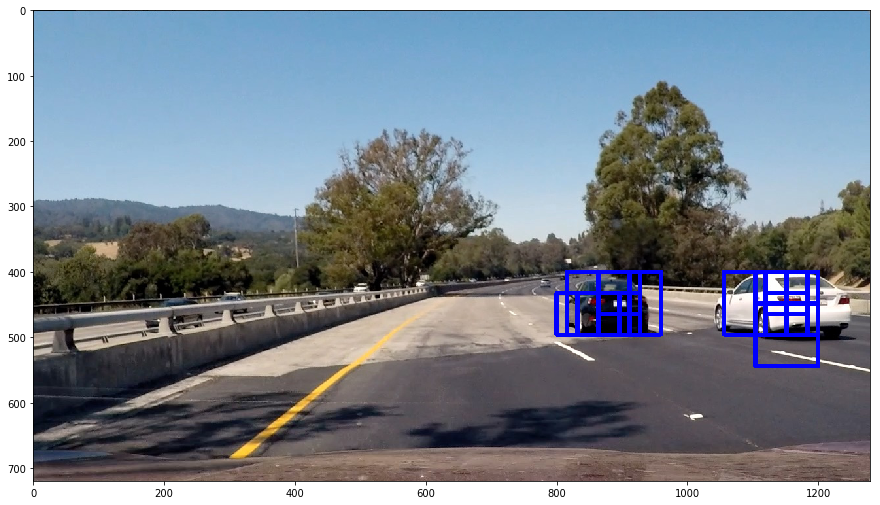

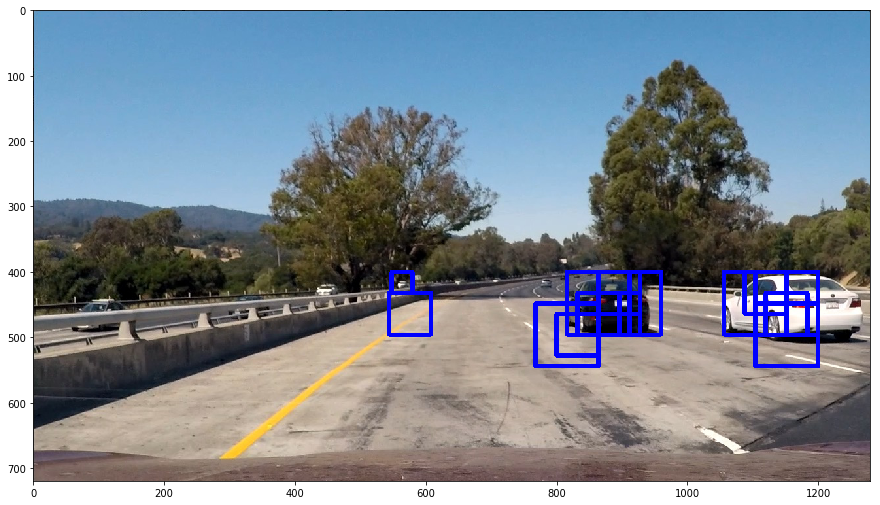

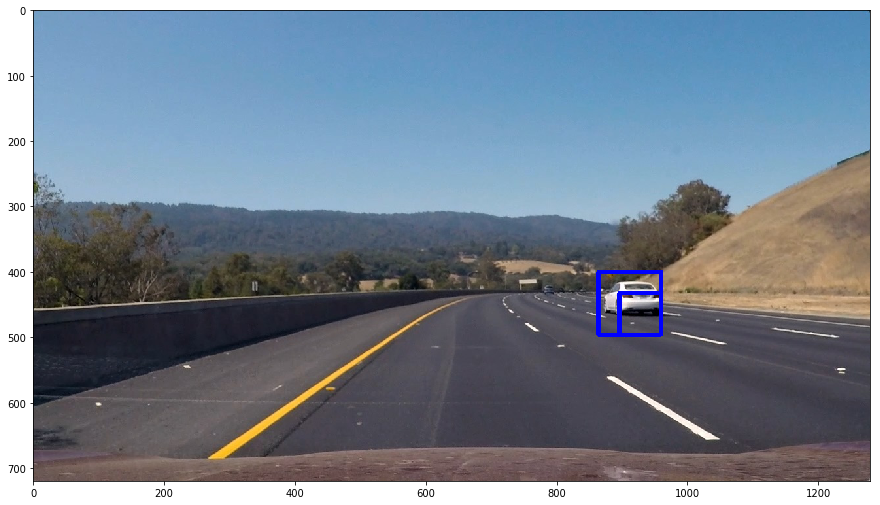

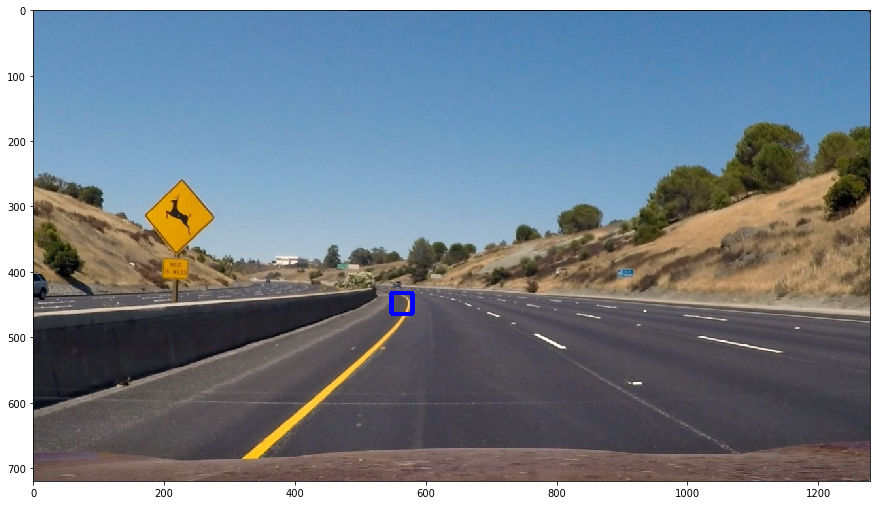

In [13]:
%matplotlib inline
test_files = glob.glob('./test_images/*.jpg')

for filename in test_files:
    img = mpimg.imread(filename)
    draw_img = np.copy(img)

    bboxes = tiered_window_search(img)
    
    for bbx in bboxes:
        cv2.rectangle(draw_img,bbx[0],bbx[1],(0,0,255),6)
    fig = plt.figure(figsize=(15,9))
    plt.imshow(draw_img)
    plt.savefig('output_images/test_bboxes_{}'.format(filename.split('/')[-1]))

## Video Generation

In [14]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import os

In [15]:
def tiered_window_search_video(img):
    draw_img = np.copy(img)
    bboxes = []
    
    xstart = 500
    xstop = 850
    ystart = 400
    ystop = 475
    scale = 0.5

    bboxes = bboxes + find_cars(img, color_space, xstart, xstop, ystart, ystop, scale, svc, X_scaler,
                        orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, spatial_feat)
    
    xstart = 0
    xstop = 1200
    ystart = 400
    ystop = 550
    scale = 1
    
    bboxes = bboxes + find_cars(img, color_space, xstart, xstop, ystart, ystop, scale, svc, X_scaler,
                        orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, spatial_feat)
    
    ystart = 400
    ystop = 650
    scale = 1.5
    
    bboxes = bboxes + find_cars(img, color_space, xstart, xstop, ystart, ystop, scale, svc, X_scaler,
                        orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, spatial_feat)
    
    ystart = 450
    ystop = 700
    scale = 2
    
    bboxes = bboxes + find_cars(img, color_space, xstart, xstop, ystart, ystop, scale, svc, X_scaler,
                        orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, spatial_feat)
    
    for bbx in bboxes:
        cv2.rectangle(draw_img,bbx[0],bbx[1],(0,0,255),6)
    return draw_img

In [19]:
out_video_dir = "output_video_images"
if not os.path.exists(out_video_dir):
    os.mkdir(out_video_dir)
video_output = out_video_dir + '/vehicles_rough2.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
# clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
video_clip = VideoFileClip("project_video.mp4")
clip = video_clip.fl_image(tiered_window_search_video) #NOTE: this function expects color images!!
%time clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video output_video_images/vehicles_rough2.mp4
[MoviePy] Writing video output_video_images/vehicles_rough2.mp4


100%|█████████▉| 1260/1261 [07:32<00:00,  2.85it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video_images/vehicles_rough2.mp4 

CPU times: user 7min 13s, sys: 16.1 s, total: 7min 29s
Wall time: 7min 33s


In [20]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

In [29]:
from scipy.ndimage.measurements import label

# Define a function that generates a heatmap from a list of bboxes
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap
    
# Define a function that thresholds heatmap to filter out noise
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

from scipy.ndimage.measurements import label

# Define a function that draws bboxes around an image with distinct features
def draw_labeled_bboxes(img, labels):
    labels = label(img)
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,255,), 20)
    # Return the image
    return img

def tiered_window_search_smoothed(img):
    
    global recent_heat_maps, frame_ind
    
    draw_img = np.copy(img)
    bboxes = []
    
    xstart = 500
    xstop = 850
    ystart = 400
    ystop = 475
    scale = 0.5

    bboxes = bboxes + find_cars(img, color_space, xstart, xstop, ystart, ystop, scale, svc, X_scaler,
                        orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, spatial_feat)
    
    xstart = 0
    xstop = 1200
    ystart = 400
    ystop = 550
    scale = 1
    
    bboxes = bboxes + find_cars(img, color_space, xstart, xstop, ystart, ystop, scale, svc, X_scaler,
                        orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, spatial_feat)
    
    ystart = 400
    ystop = 650
    scale = 1.5
    
    bboxes = bboxes + find_cars(img, color_space, xstart, xstop, ystart, ystop, scale, svc, X_scaler,
                        orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, spatial_feat)
    
    ystart = 450
    ystop = 700
    scale = 2
    
    bboxes = bboxes + find_cars(img, color_space, xstart, xstop, ystart, ystop, scale, svc, X_scaler,
                        orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, spatial_feat)
    
    if (frame_ind == 0):
        recent_heat_map = np.zeros_like(img[:,:,0]).astype(np.float)

    heat_map = add_heat(recent_heat_map, bboxes)
    heat_map = apply_threshold(heat_map,1)
    labels = label(heat_map)

    draw_img = draw_labeled_bboxes(draw_img, labels)
    
    recent_heat_map = apply_threshold(recent_heat_map, 1)
    frame_ind = 0
        
    return draw_img

In [30]:
frame_ind = 0

out_video_dir = "output_video_images"
if not os.path.exists(out_video_dir):
    os.mkdir(out_video_dir)
video_output = out_video_dir + '/vehicles_filtered.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
# clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
video_clip = VideoFileClip("project_video.mp4")
clip = video_clip.fl_image(tiered_window_search_smoothed) #NOTE: this function expects color images!!
%time clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video output_video_images/vehicles_filtered.mp4
[MoviePy] Writing video output_video_images/vehicles_filtered.mp4


100%|█████████▉| 1260/1261 [14:47<00:00,  1.28it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video_images/vehicles_filtered.mp4 

CPU times: user 13min 14s, sys: 1min 21s, total: 14min 35s
Wall time: 14min 48s


In [31]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))